In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import os
import pydub

In [3]:
df = pd.read_csv("../data/label.csv")

In [4]:
df.shape
print(df)

       Unnamed: 0  singer  duet  plucking  world  bongos  harpsichord  sitar   
0               0   False     0         0      0       0        False      0  \
1               1   False     0         0      0       0        False      0   
2               2   False     0         0      0       0        False      0   
3               3   False     0         0      0       0        False      0   
4               4   False     0         0      0       0        False      0   
...           ...     ...   ...       ...    ...     ...          ...    ...   
26858       26858   False     0         0      0       0        False      0   
26859       26859   False     0         0      0       0        False      0   
26860       26860   False     0         0      0       0        False      0   
26861       26861   False     0         0      0       0        False      0   
26862       26862   False     0         0      0       0        False      0   

       chorus  female opera  ...  noise

In [5]:
counts = df.sum()
print(counts)

Unnamed: 0                                             360796953
singer                                                      1308
duet                                                          74
plucking                                                      69
world                                                         65
                                     ...                        
baroque                                                      297
fiddle                                                        86
english                                                       61
filepath       mtat/f/american_bach_soloists-j_s__bach_solo_c...
data_origin                                                25863
Length: 137, dtype: object


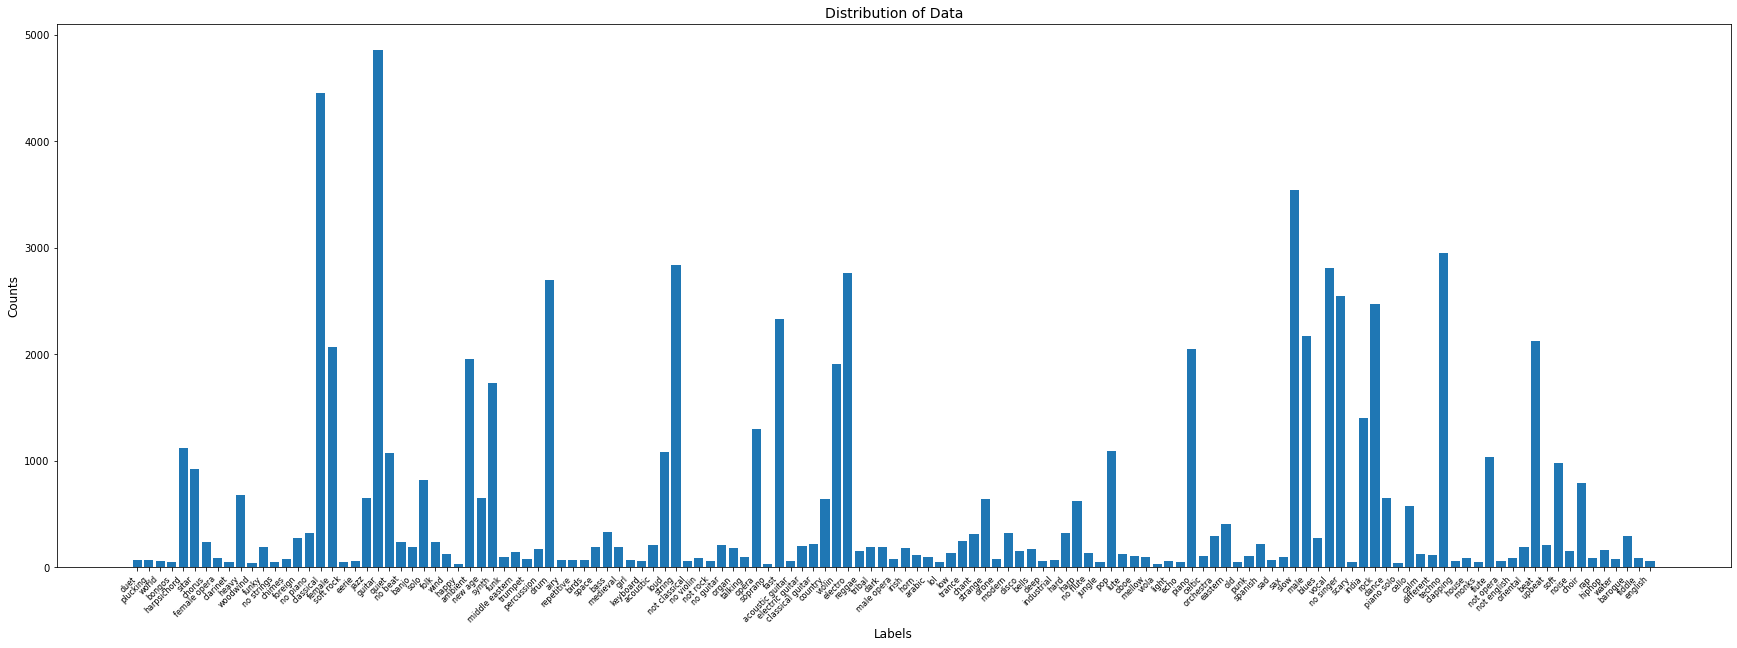

In [6]:
data_values = pd.to_numeric(counts.iloc[2:-2])

# Create a larger figure
plt.figure(figsize=(30, 10))  # Adjust the width and height as needed

# Plot the values against the index labels
plt.bar(data_values.index, data_values)

# Adjust x-axis label font size and rotation
plt.xticks(rotation=45, ha='right', fontsize=8)  # Adjust the fontsize parameter as needed

plt.xlabel('Labels', fontsize=12)  # Adjust the fontsize parameter as needed
plt.ylabel('Counts', fontsize=12)  # Adjust the fontsize parameter as needed
plt.title('Distribution of Data', fontsize=14)  # Adjust the fontsize parameter as needed

plt.show()

We can clearly see imbalance in the labels. I think we can either join some labels(drum,drums), or do over/under sampling. Not sure about data augmentation.

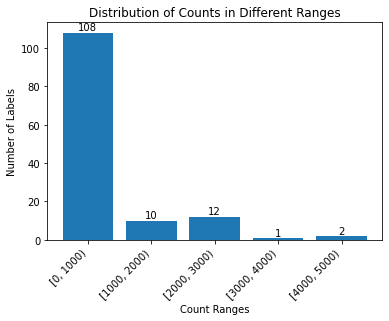

In [7]:
# Create bins for counts
bins = [0, 1000, 2000, 3000, 4000, 5000]  # Define your bin ranges

# Use pd.cut to categorize values into bins
count_bins = pd.cut(data_values, bins=bins, right=False)

# Count the number of occurrences in each bin
count_bin_counts = count_bins.value_counts().sort_index()

# Plot the distribution
plt.bar(count_bin_counts.index.astype(str), count_bin_counts)

for i, count in enumerate(count_bin_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.xticks(rotation=45, ha='right', fontsize=10)

plt.xlabel('Count Ranges')
plt.ylabel('Number of Labels')
plt.title('Distribution of Counts in Different Ranges')
plt.show()

Checking channels

In [8]:
# Specify a list of directories containing your audio files
audio_directories = ['../data/mtat/0', '../data/mtat/1','../data/mtat/2','../data/mtat/3','../data/mtat/4','../data/mtat/5','../data/mtat/6','../data/mtat/7','../data/mtat/8','../data/mtat/9','../data/mtat/a','../data/mtat/b','../data/mtat/c','../data/mtat/d','../data/mtat/e','../data/mtat/f' ]

# Get a list of all audio files in the specified directories
audio_files = []
for directory in audio_directories:
    audio_files.extend([os.path.join(directory, file) for file in os.listdir(directory)])

In [9]:
# Substrings to exclude
substrings_to_exclude = [
    "norine_braun-now_and_zen-08-gently-117-146.mp3",
    "jacob_heringman-josquin_des_prez_lute_settings-19-gintzler__pater_noster-204-233.mp3",
    "american_baroque-dances_and_suites_of_rameau_and_couperin-25-le_petit_rien_xiveme_ordre_couperin-88-117.mp3",
]

# Iterate through the list and remove elements containing the specified substrings
audio_files = [path for path in audio_files if not any(substring in path for substring in substrings_to_exclude)]

# Print the updated list
print(audio_files)

['../data/mtat/0/william_brooks-bitter_circus-10-my_love_looks_the_other_way-59-88.mp3', '../data/mtat/0/barbara_leoni-human_needs-06-haunted-117-146.mp3', '../data/mtat/0/the_bots-truth-02-power_and_domination-59-88.mp3', '../data/mtat/0/williamson-a_few_things_to_hear_before_we_all_blow_up-11-whiffle-146-175.mp3', '../data/mtat/0/williamson-a_few_things_to_hear_before_we_all_blow_up-04-time_youll_never_get_back-175-204.mp3', '../data/mtat/0/barbara_leoni-human_needs-06-haunted-146-175.mp3', '../data/mtat/0/beth_quist-silver-07-padip-0-29.mp3', '../data/mtat/0/voices_of_music-an_evening_with_bach-15-passacaglia_mein_freund_ist_mein_j_c__bach-320-349.mp3', '../data/mtat/0/the_bots-truth-12-rock_on-30-59.mp3', '../data/mtat/0/rocket_city_riot-middle_age_suicide-01-all_i_got-0-29.mp3', '../data/mtat/0/williamson-a_few_things_to_hear_before_we_all_blow_up-03-raining_at_the_crescent_house-117-146.mp3', '../data/mtat/0/satori-sounds_for_meditation-01-meditation_1-175-204.mp3', '../data/mtat

For fun

In [13]:
from pydub import AudioSegment

def create_metadata(audio_file):
    
    audio = AudioSegment.from_file(audio_file)
    
    num_channels = audio.channels
    sampling_rate = audio.frame_rate

    duration_seconds = len(audio) / 1000
    
    return sampling_rate, num_channels, duration_seconds

In [14]:
print(create_metadata('../data/mtat/0/american_bach_soloists-j_s__bach__cantatas_volume_v-01-gleichwie_der_regen_und_schnee_vom_himmel_fallt_bwv_18_i_sinfonia-117-146.mp3'))

(16000, 1, 29.124)


In [15]:
# Initialize an empty list to store the data
metadata = []
error_files = []  # List to store paths of problematic files

# Iterate over the filepaths in the subset DataFrame
for file in audio_files:
    try:
        sampling_rate, num_channels, duration_seconds = create_metadata(file)
        # Create a dictionary of the data you want to store
        audio_info = {
            'filepath': file,
            'audio_channels': num_channels, 
            'sampling_rate': sampling_rate,
            'audio_length': duration_seconds,
            # Add more features if needed
        }
        # Append the dictionary to your list
        metadata.append( audio_info)

    except Exception as e: 
        print(f"Failed to process {file}: {e}")  # Corrected to use 'file' instead of 'value'
        error_files.append({'filepath': file, 'error': str(e)})

# Convert the list of dictionaries to a new DataFrame
metadata_df = pd.DataFrame(metadata)
error_df = pd.DataFrame(error_files)

In [16]:
metadata_df

,filepath,audio_channels,sampling_rate,audio_length
0,../data/mtat/0/william_brooks-bitter_circus-10...,1,16000,29.124
1,../data/mtat/0/barbara_leoni-human_needs-06-ha...,1,16000,29.124
2,../data/mtat/0/the_bots-truth-02-power_and_dom...,1,16000,29.124
3,../data/mtat/0/williamson-a_few_things_to_hear...,1,16000,29.124
4,../data/mtat/0/williamson-a_few_things_to_hear...,1,16000,29.124
...,...,...,...,...
25855,../data/mtat/f/dac_crowell-redshifted_harmonie...,1,16000,29.124
25856,../data/mtat/f/paul_berget-sl_weiss_on_11_stri...,1,16000,29.124
25857,../data/mtat/f/brad_sucks-i_dont_know_what_im_...,1,16000,29.124
25858,../data/mtat/f/hans_christian-surrender-02-tea...,1,16000,29.124


In [18]:
unique_values_count = metadata_df['audio_length'].nunique()
print(f"Number of unique values in : {unique_values_count}")

Number of unique values in : 1
